In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import time
import os

## Define FCN16s model for deconvolution layers

In [2]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

## Define VGG16 for convolution layers

In [3]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [4]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Define training parameter

In [5]:
batch_size = 12
epochs     = 100  #500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 5
gamma      = 0.5
model_use  = "box_gan" # "unity" "histogram" "box_gan"
n_class = 21

## Define path, directory trainning environment

In [6]:
# get data
data_dir  = os.path.join("/media/arg_ws3/5E703E3A703E18EB/data/mm_FCN", model_use)
if not os.path.exists(data_dir):
    print("Data not found!")
# create dir for model
model_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/mm_fcn/models", model_use)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# create dir for score
score_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/mm_fcn/scores", model_use)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
#use_gpu = False
if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

Finish cuda loading, time elapsed 9.996058464050293


Dataset class
-------------

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample

Let's create a dataset class for our face landmarks dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.



In [7]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
val_h     = h
val_w     = w
brand_class = ['3m', 'andes', 'cocacola', 'crayola', 'folgers','heineken','hunts','kellogg','kleenex',\
               'kotex','libava','macadamia','milo','mm','pocky','raisins','stax','swissmiss','vanish','viva']
class product_dataset(Dataset):

    def __init__(self, csv_file, phase, n_class=n_class, flip_rate=0.):
        self.data      = pd.read_csv(csv_file)
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate
        if phase == 'train':
            self.flip_rate = 0.5

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name   = self.data.iloc[idx, 0]
        img        = cv2.imread(os.path.join(data_dir, img_name),cv2.IMREAD_UNCHANGED)
        label_name = self.data.iloc[idx, 1]
        label      = cv2.imread(os.path.join(data_dir, label_name), cv2.IMREAD_GRAYSCALE)
        origin_img = img
        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)

        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)
        
        '''for i in range(n_class - 1):
            if brand_class[i] in img_name:
                target[i+1][label != 0] = 1
                label[label != 0] = i+1
                #print(brand_class[i], img_name,label_name)'''
        for i in range(n_class):
            target[i][label == i] = 1
        
        #target[0][label == 0] = 1
        #print(np.unique(label))
        
 
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img}

        return sample

## Define dataloader and optimizer

In [8]:
# initial dataloader for trainning and validation
train_file = os.path.join(data_dir, "train.csv")
val_file   = os.path.join(data_dir, "test.csv")
train_data = product_dataset(csv_file = train_file, phase = 'train')
val_data   = product_dataset(csv_file = val_file, phase = 'val', flip_rate = 0)
dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers = 0)
val_loader = DataLoader(val_data, batch_size = 4, num_workers = 0)

dataiter = iter(val_loader)

# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr = lr, momentum = momentum, weight_decay = w_decay)
# decay LR by a factor of 0.5 every step_size = 50 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)  

## Train

In [9]:
def train():
    for epoch in range(epochs):
        fcn_model.train()
        scheduler.step()
        configs    = "FCNs_{}_batch{}_epoch{}_RMSprop_lr{}"\
            .format(model_use, batch_size, epoch, lr)
        model_path = os.path.join(model_dir, configs)
        
        ts = time.time()
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch+1, iter, loss.item()))
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        if epoch % 1 == 0:
            torch.save(fcn_model.state_dict(),model_path + '.pkl')

        val(epoch)

## Evaluation

In [10]:
def val(epoch):
    fcn_model.eval()
    TP = np.zeros(n_class-1, dtype = np.float128)
    FN = np.zeros(n_class-1, dtype = np.float128)
    FP = np.zeros(n_class-1, dtype = np.float128)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        output = fcn_model(inputs)
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(epoch, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('epoch:'+ str(epoch) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('epoch:'+ str(epoch) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('epoch:'+ str(epoch) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('epoch:'+ str(epoch) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('epoch:'+ str(epoch) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('epoch:'+ str(epoch) + ', class fscore: ' + str(fscore) + '\n' )  
    

def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class, dtype = np.float128)
    FN = np.zeros(n_class, dtype = np.float128)
    FP = np.zeros(n_class, dtype = np.float128)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [11]:
train()

epoch1, iter0, loss: 0.7284237742424011
epoch1, iter10, loss: 0.7145917415618896
epoch1, iter20, loss: 0.7085756063461304
epoch1, iter30, loss: 0.7057270407676697
epoch1, iter40, loss: 0.7024599313735962
epoch1, iter50, loss: 0.6972203850746155
epoch1, iter60, loss: 0.6922723054885864
epoch1, iter70, loss: 0.6905877590179443
epoch1, iter80, loss: 0.688776969909668
epoch1, iter90, loss: 0.6878448724746704
epoch1, iter100, loss: 0.6832419037818909
epoch1, iter110, loss: 0.6835058331489563
epoch1, iter120, loss: 0.679868757724762
epoch1, iter130, loss: 0.6761588454246521
epoch1, iter140, loss: 0.6779749393463135
epoch1, iter150, loss: 0.6753265857696533
epoch1, iter160, loss: 0.6730733513832092
epoch1, iter170, loss: 0.6697127223014832
epoch1, iter180, loss: 0.6688551306724548
epoch1, iter190, loss: 0.6656535267829895
epoch1, iter200, loss: 0.6617913246154785
epoch1, iter210, loss: 0.6599583625793457
epoch1, iter220, loss: 0.6606767177581787
epoch1, iter230, loss: 0.6555362939834595
epoch

epoch1, iter1930, loss: 0.177648663520813
epoch1, iter1940, loss: 0.17505761981010437
epoch1, iter1950, loss: 0.17361535131931305
epoch1, iter1960, loss: 0.17088907957077026
epoch1, iter1970, loss: 0.16951312124729156
epoch1, iter1980, loss: 0.16641443967819214
epoch1, iter1990, loss: 0.16671845316886902
epoch1, iter2000, loss: 0.1624024212360382
epoch1, iter2010, loss: 0.16200193762779236
epoch1, iter2020, loss: 0.15979710221290588
epoch1, iter2030, loss: 0.1585211455821991
epoch1, iter2040, loss: 0.15544334053993225
epoch1, iter2050, loss: 0.1535988450050354
epoch1, iter2060, loss: 0.15148700773715973
epoch1, iter2070, loss: 0.14991620182991028
epoch1, iter2080, loss: 0.14814525842666626
epoch1, iter2090, loss: 0.1460576355457306
epoch1, iter2100, loss: 0.14504733681678772
epoch1, iter2110, loss: 0.1433705985546112
epoch1, iter2120, loss: 0.14124689996242523
epoch1, iter2130, loss: 0.14220695197582245
epoch1, iter2140, loss: 0.1370261311531067
epoch1, iter2150, loss: 0.13630162179470

epoch1, iter3790, loss: 0.022577675059437752
epoch1, iter3800, loss: 0.017086833715438843
epoch1, iter3810, loss: 0.018766015768051147
epoch1, iter3820, loss: 0.019223354756832123
epoch1, iter3830, loss: 0.020027337595820427
epoch1, iter3840, loss: 0.016808317974209785
epoch1, iter3850, loss: 0.02040703408420086
epoch1, iter3860, loss: 0.01803145371377468
epoch1, iter3870, loss: 0.01968405395746231
epoch1, iter3880, loss: 0.018098009750247
epoch1, iter3890, loss: 0.018695957958698273
epoch1, iter3900, loss: 0.019718090072274208
epoch1, iter3910, loss: 0.02125098556280136
epoch1, iter3920, loss: 0.01413100864738226
epoch1, iter3930, loss: 0.015916259959340096
epoch1, iter3940, loss: 0.016755560413002968
epoch1, iter3950, loss: 0.019656101241707802
epoch1, iter3960, loss: 0.014759312383830547
epoch1, iter3970, loss: 0.016006940975785255
epoch1, iter3980, loss: 0.014756901189684868
epoch1, iter3990, loss: 0.012691199779510498
epoch1, iter4000, loss: 0.01518082246184349
epoch1, iter4010, l

epoch2, iter250, loss: 0.00587766757234931
epoch2, iter260, loss: 0.005893315654247999
epoch2, iter270, loss: 0.009221967309713364
epoch2, iter280, loss: 0.0038059521466493607
epoch2, iter290, loss: 0.004914173856377602
epoch2, iter300, loss: 0.007096195127815008
epoch2, iter310, loss: 0.009902293793857098
epoch2, iter320, loss: 0.007798890117555857
epoch2, iter330, loss: 0.0062078628689050674
epoch2, iter340, loss: 0.0052540297619998455
epoch2, iter350, loss: 0.003943586256355047
epoch2, iter360, loss: 0.005273615941405296
epoch2, iter370, loss: 0.005316532216966152
epoch2, iter380, loss: 0.0055191973224282265
epoch2, iter390, loss: 0.006660526618361473
epoch2, iter400, loss: 0.004906530026346445
epoch2, iter410, loss: 0.007321979384869337
epoch2, iter420, loss: 0.004676468204706907
epoch2, iter430, loss: 0.004748835228383541
epoch2, iter440, loss: 0.007003729697316885
epoch2, iter450, loss: 0.003942545037716627
epoch2, iter460, loss: 0.00746040977537632
epoch2, iter470, loss: 0.00620

epoch2, iter2080, loss: 0.0021053298842161894
epoch2, iter2090, loss: 0.0010280488058924675
epoch2, iter2100, loss: 0.0017577360849827528
epoch2, iter2110, loss: 0.0020113345235586166
epoch2, iter2120, loss: 0.0010842590127140284
epoch2, iter2130, loss: 0.0017615978140383959
epoch2, iter2140, loss: 0.010896792635321617
epoch2, iter2150, loss: 0.0027754101902246475
epoch2, iter2160, loss: 0.002778385765850544
epoch2, iter2170, loss: 0.0015974800335243344
epoch2, iter2180, loss: 0.0020444542169570923
epoch2, iter2190, loss: 0.0013896123273298144
epoch2, iter2200, loss: 0.0017029923619702458
epoch2, iter2210, loss: 0.0016798789147287607
epoch2, iter2220, loss: 0.0014512011548504233
epoch2, iter2230, loss: 0.002343118656426668
epoch2, iter2240, loss: 0.0011860213708132505
epoch2, iter2250, loss: 0.002069788984954357
epoch2, iter2260, loss: 0.003622940042987466
epoch2, iter2270, loss: 0.0038950094021856785
epoch2, iter2280, loss: 0.0016864107456058264
epoch2, iter2290, loss: 0.0018381124828

epoch2, iter3880, loss: 0.0011676084250211716
epoch2, iter3890, loss: 0.0007136691710911691
epoch2, iter3900, loss: 0.0005967930774204433
epoch2, iter3910, loss: 0.0009035553666763008
epoch2, iter3920, loss: 0.0008068550378084183
epoch2, iter3930, loss: 0.0010896561434492469
epoch2, iter3940, loss: 0.003073596628382802
epoch2, iter3950, loss: 0.010839661583304405
epoch2, iter3960, loss: 0.0009198755142278969
epoch2, iter3970, loss: 0.0010461157653480768
epoch2, iter3980, loss: 0.0012148666428402066
epoch2, iter3990, loss: 0.0009303232654929161
epoch2, iter4000, loss: 0.0008647221839055419
epoch2, iter4010, loss: 0.0009318459779024124
epoch2, iter4020, loss: 0.000508009921759367
epoch2, iter4030, loss: 0.0008887614239938557
epoch2, iter4040, loss: 0.0006329338066279888
epoch2, iter4050, loss: 0.0017651614034548402
epoch2, iter4060, loss: 0.002199857961386442
epoch2, iter4070, loss: 0.001323361531831324
epoch2, iter4080, loss: 0.00042874563951045275
epoch2, iter4090, loss: 0.000465233635

epoch3, iter300, loss: 0.011995152570307255
epoch3, iter310, loss: 0.0006797448731958866
epoch3, iter320, loss: 0.004037181381136179
epoch3, iter330, loss: 0.003909596707671881
epoch3, iter340, loss: 0.0006715075578540564
epoch3, iter350, loss: 0.001778318895958364
epoch3, iter360, loss: 0.0004414056893438101
epoch3, iter370, loss: 0.010545811615884304
epoch3, iter380, loss: 0.0015362154226750135
epoch3, iter390, loss: 0.001914604683406651
epoch3, iter400, loss: 0.0008383463136851788
epoch3, iter410, loss: 0.0007757073035463691
epoch3, iter420, loss: 0.0004589723248500377
epoch3, iter430, loss: 0.0007282086880877614
epoch3, iter440, loss: 0.0006044498877599835
epoch3, iter450, loss: 0.0004544314870145172
epoch3, iter460, loss: 0.00035948975710198283
epoch3, iter470, loss: 0.001056700712069869
epoch3, iter480, loss: 0.0003080090682487935
epoch3, iter490, loss: 0.001976852538064122
epoch3, iter500, loss: 0.0005332528380677104
epoch3, iter510, loss: 0.0005156589904800057
epoch3, iter520, 

epoch3, iter2100, loss: 0.0006974743446335196
epoch3, iter2110, loss: 0.0004797823494300246
epoch3, iter2120, loss: 0.00035700236912816763
epoch3, iter2130, loss: 0.0007372237159870565
epoch3, iter2140, loss: 0.0003178339102305472
epoch3, iter2150, loss: 0.0007794762495905161
epoch3, iter2160, loss: 0.0002859770320355892
epoch3, iter2170, loss: 0.0005175158730708063
epoch3, iter2180, loss: 0.00032751806429587305
epoch3, iter2190, loss: 0.0010586419375613332
epoch3, iter2200, loss: 0.00039799706428311765
epoch3, iter2210, loss: 0.0003119274915661663
epoch3, iter2220, loss: 0.0003607886901590973
epoch3, iter2230, loss: 0.004155064933001995
epoch3, iter2240, loss: 0.0017548294272273779
epoch3, iter2250, loss: 0.001770277158357203
epoch3, iter2260, loss: 0.0006176586612127721
epoch3, iter2270, loss: 0.0005132478545419872
epoch3, iter2280, loss: 0.0006163888610899448
epoch3, iter2290, loss: 0.00029034921317361295
epoch3, iter2300, loss: 0.0004416505107656121
epoch3, iter2310, loss: 0.000712

epoch3, iter3880, loss: 0.0026882581878453493
epoch3, iter3890, loss: 0.0007155147613957524
epoch3, iter3900, loss: 0.0003829447668977082
epoch3, iter3910, loss: 0.00045263240463100374
epoch3, iter3920, loss: 0.00036529451608657837
epoch3, iter3930, loss: 0.00037068562232889235
epoch3, iter3940, loss: 0.0002507549652364105
epoch3, iter3950, loss: 0.0003482103056740016
epoch3, iter3960, loss: 0.000761955336201936
epoch3, iter3970, loss: 0.0002591955417301506
epoch3, iter3980, loss: 0.0002382432867307216
epoch3, iter3990, loss: 0.0005270436522550881
epoch3, iter4000, loss: 0.00035457787453196943
epoch3, iter4010, loss: 0.0014958818210288882
epoch3, iter4020, loss: 0.0004964988911524415
epoch3, iter4030, loss: 0.0004398337914608419
epoch3, iter4040, loss: 0.00028774901875294745
epoch3, iter4050, loss: 0.0034384632017463446
epoch3, iter4060, loss: 0.0023084967397153378
epoch3, iter4070, loss: 0.0007342748576775193
epoch3, iter4080, loss: 0.0007727862102910876
epoch3, iter4090, loss: 0.0004

epoch4, iter290, loss: 0.0011598202399909496
epoch4, iter300, loss: 0.0005209779483266175
epoch4, iter310, loss: 0.0004566796123981476
epoch4, iter320, loss: 0.00034312051138840616
epoch4, iter330, loss: 0.00033961667213588953
epoch4, iter340, loss: 0.00023636440164409578
epoch4, iter350, loss: 0.00037198050995357335
epoch4, iter360, loss: 0.00030806526774540544
epoch4, iter370, loss: 0.00030522100860252976
epoch4, iter380, loss: 0.00022327782062347978
epoch4, iter390, loss: 0.0002655361022334546
epoch4, iter400, loss: 0.0002764242817647755
epoch4, iter410, loss: 0.00021614771685563028
epoch4, iter420, loss: 0.00026234349934384227
epoch4, iter430, loss: 0.0004653345386032015
epoch4, iter440, loss: 0.0002375840995227918
epoch4, iter450, loss: 0.0003851067158393562
epoch4, iter460, loss: 0.00033601594623178244
epoch4, iter470, loss: 0.00022320555581245571
epoch4, iter480, loss: 0.0005852326285094023
epoch4, iter490, loss: 0.0005572262452915311
epoch4, iter500, loss: 0.0002900933031924069

epoch4, iter2080, loss: 0.00022638730297330767
epoch4, iter2090, loss: 0.007886772975325584
epoch4, iter2100, loss: 0.00040835776599124074
epoch4, iter2110, loss: 0.00206560455262661
epoch4, iter2120, loss: 0.0005542169092223048
epoch4, iter2130, loss: 0.00029851216822862625
epoch4, iter2140, loss: 0.000669938453938812
epoch4, iter2150, loss: 0.0002929864567704499
epoch4, iter2160, loss: 0.000244383787503466
epoch4, iter2170, loss: 0.00034159369533881545
epoch4, iter2180, loss: 0.0002904317225329578
epoch4, iter2190, loss: 0.00043749381438829005
epoch4, iter2200, loss: 0.0002665851206984371
epoch4, iter2210, loss: 0.00033244426595047116
epoch4, iter2220, loss: 0.00032225760514847934
epoch4, iter2230, loss: 0.0003194609598722309
epoch4, iter2240, loss: 0.00040839609573595226
epoch4, iter2250, loss: 0.00027754154871217906
epoch4, iter2260, loss: 0.00038514527841471136
epoch4, iter2270, loss: 0.00030430819606408477
epoch4, iter2280, loss: 0.0004171098698861897
epoch4, iter2290, loss: 0.00

epoch4, iter3860, loss: 0.000874516146723181
epoch4, iter3870, loss: 0.000599969644099474
epoch4, iter3880, loss: 0.00039706038660369813
epoch4, iter3890, loss: 0.0004622969136107713
epoch4, iter3900, loss: 0.0004198445240035653
epoch4, iter3910, loss: 0.00042869782191701233
epoch4, iter3920, loss: 0.0003199509810656309
epoch4, iter3930, loss: 0.00028868866502307355
epoch4, iter3940, loss: 0.00046257267240434885
epoch4, iter3950, loss: 0.0002902257547248155
epoch4, iter3960, loss: 0.0003135926090180874
epoch4, iter3970, loss: 0.00026089721359312534
epoch4, iter3980, loss: 0.00026557003729976714
epoch4, iter3990, loss: 0.0011560177663341165
epoch4, iter4000, loss: 0.0002583525492809713
epoch4, iter4010, loss: 0.0002852831967175007
epoch4, iter4020, loss: 0.0005003060214221478
epoch4, iter4030, loss: 0.00032027988345362246
epoch4, iter4040, loss: 0.0012425766326487064
epoch4, iter4050, loss: 0.006851745303720236
epoch4, iter4060, loss: 0.0006673114839941263
epoch4, iter4070, loss: 0.0003

epoch5, iter270, loss: 0.00031255013891495764
epoch5, iter280, loss: 0.00027098989812657237
epoch5, iter290, loss: 0.00019075852469541132
epoch5, iter300, loss: 0.0002800108049996197
epoch5, iter310, loss: 0.00022358118440024555
epoch5, iter320, loss: 0.0002378219651291147
epoch5, iter330, loss: 0.0004413192218635231
epoch5, iter340, loss: 0.0003081528120674193
epoch5, iter350, loss: 0.00027023395523428917
epoch5, iter360, loss: 0.00024339031369891018
epoch5, iter370, loss: 0.0002001674147322774
epoch5, iter380, loss: 0.000281706074019894
epoch5, iter390, loss: 0.0002622200991027057
epoch5, iter400, loss: 0.0004496078472584486
epoch5, iter410, loss: 0.0012062229216098785
epoch5, iter420, loss: 0.00038074771873652935
epoch5, iter430, loss: 0.0006983843049965799
epoch5, iter440, loss: 0.0005278378375805914
epoch5, iter450, loss: 0.0006089413654990494
epoch5, iter460, loss: 0.0026737188454717398
epoch5, iter470, loss: 0.0005546844331547618
epoch5, iter480, loss: 0.0002407768915873021
epoc

epoch5, iter2060, loss: 0.00021519437723327428
epoch5, iter2070, loss: 0.00053118058713153
epoch5, iter2080, loss: 0.0002862780529540032
epoch5, iter2090, loss: 0.00031198185752145946
epoch5, iter2100, loss: 0.000285597809124738
epoch5, iter2110, loss: 0.0002579389256425202
epoch5, iter2120, loss: 0.00037115757004357874
epoch5, iter2130, loss: 0.0003052612883038819
epoch5, iter2140, loss: 0.0002867110015358776
epoch5, iter2150, loss: 0.0002259062312077731
epoch5, iter2160, loss: 0.00024752860190346837
epoch5, iter2170, loss: 0.00036245983210392296
epoch5, iter2180, loss: 0.00040228647412732244
epoch5, iter2190, loss: 0.00034702467382885516
epoch5, iter2200, loss: 0.0003039925650227815
epoch5, iter2210, loss: 0.00028964196098968387
epoch5, iter2220, loss: 0.00032659125281497836
epoch5, iter2230, loss: 0.0004243359435349703
epoch5, iter2240, loss: 0.0002951138012576848
epoch5, iter2250, loss: 0.0002638925507199019
epoch5, iter2260, loss: 0.0004345280467532575
epoch5, iter2270, loss: 0.00

epoch5, iter3830, loss: 0.0005394952022470534
epoch5, iter3840, loss: 0.000346534070558846
epoch5, iter3850, loss: 0.0003446863847784698
epoch5, iter3860, loss: 0.00019295740639790893
epoch5, iter3870, loss: 0.000498437148053199
epoch5, iter3880, loss: 0.0002749571285676211
epoch5, iter3890, loss: 0.0001835103757912293
epoch5, iter3900, loss: 0.00017663161270320415
epoch5, iter3910, loss: 0.000319915619911626
epoch5, iter3920, loss: 0.0025331429205834866
epoch5, iter3930, loss: 0.0011135338572785258
epoch5, iter3940, loss: 0.00022716235253028572
epoch5, iter3950, loss: 0.0004537431232165545
epoch5, iter3960, loss: 0.00021481224393937737
epoch5, iter3970, loss: 0.00023637489357497543
epoch5, iter3980, loss: 0.000280761974863708
epoch5, iter3990, loss: 0.0004255665699020028
epoch5, iter4000, loss: 0.0003282039542682469
epoch5, iter4010, loss: 0.00024372708867304027
epoch5, iter4020, loss: 0.00019414402777329087
epoch5, iter4030, loss: 0.00029916566563770175
epoch5, iter4040, loss: 0.0003

epoch6, iter230, loss: 0.00019184684788342565
epoch6, iter240, loss: 0.0005747199757024646
epoch6, iter250, loss: 0.00027351651806384325
epoch6, iter260, loss: 0.00020687913638539612
epoch6, iter270, loss: 0.00028546227258630097
epoch6, iter280, loss: 0.000220386718865484
epoch6, iter290, loss: 0.0003598243638407439
epoch6, iter300, loss: 0.00039513123920187354
epoch6, iter310, loss: 0.00027526370831765234
epoch6, iter320, loss: 0.0001897149923024699
epoch6, iter330, loss: 0.0002321050560567528
epoch6, iter340, loss: 0.00015464973694179207
epoch6, iter350, loss: 0.00043316715164110065
epoch6, iter360, loss: 0.00018155215366277844
epoch6, iter370, loss: 0.0001815930736484006
epoch6, iter380, loss: 0.0002518650144338608
epoch6, iter390, loss: 0.00025565162650309503
epoch6, iter400, loss: 0.0002574367099441588
epoch6, iter410, loss: 0.00018412974895909429
epoch6, iter420, loss: 0.00023024241090752184
epoch6, iter430, loss: 0.0002559954300522804
epoch6, iter440, loss: 0.0002377057971898466

epoch6, iter2010, loss: 0.00020713330013677478
epoch6, iter2020, loss: 0.000262593588558957
epoch6, iter2030, loss: 0.00019141181837767363
epoch6, iter2040, loss: 0.000189302081707865
epoch6, iter2050, loss: 0.00017648084030952305
epoch6, iter2060, loss: 0.0002954942174255848
epoch6, iter2070, loss: 0.0005111274658702314
epoch6, iter2080, loss: 0.00023263628827407956
epoch6, iter2090, loss: 0.0013417790178209543
epoch6, iter2100, loss: 0.0006470000371336937
epoch6, iter2110, loss: 0.00020191316434647888
epoch6, iter2120, loss: 0.0019380133599042892
epoch6, iter2130, loss: 0.00033085502218455076
epoch6, iter2140, loss: 0.00028710582409985363
epoch6, iter2150, loss: 0.00015469639038201421
epoch6, iter2160, loss: 0.00022987638658378273
epoch6, iter2170, loss: 0.00028662831755355
epoch6, iter2180, loss: 0.00037835081457160413
epoch6, iter2190, loss: 0.00037162244552746415
epoch6, iter2200, loss: 0.00019328147755004466
epoch6, iter2210, loss: 0.0002470513863954693
epoch6, iter2220, loss: 0.

epoch6, iter3770, loss: 0.0002825035771820694
epoch6, iter3780, loss: 0.00019456073641777039
epoch6, iter3790, loss: 0.0001671313657425344
epoch6, iter3800, loss: 0.0005451560718938708
epoch6, iter3810, loss: 0.0002756247704382986
epoch6, iter3820, loss: 0.00021613744320347905
epoch6, iter3830, loss: 0.00023145179147832096
epoch6, iter3840, loss: 0.0001794943236745894
epoch6, iter3850, loss: 0.00023350201081484556
epoch6, iter3860, loss: 0.00015682856610510498
epoch6, iter3870, loss: 0.0001786672364687547
epoch6, iter3880, loss: 0.0002456964866723865
epoch6, iter3890, loss: 0.00022523279767483473
epoch6, iter3900, loss: 0.00018570316024124622
epoch6, iter3910, loss: 0.00018039680435322225
epoch6, iter3920, loss: 0.00020399656204972416
epoch6, iter3930, loss: 0.0002428464067634195
epoch6, iter3940, loss: 0.0002057028323179111
epoch6, iter3950, loss: 0.00036928654299117625
epoch6, iter3960, loss: 0.00018219252524431795
epoch6, iter3970, loss: 0.0018956423737108707
epoch6, iter3980, loss:

epoch7, iter160, loss: 0.000552582845557481
epoch7, iter170, loss: 0.00022965364041738212
epoch7, iter180, loss: 0.00022705366427544504
epoch7, iter190, loss: 0.0001759987062541768
epoch7, iter200, loss: 0.0002961871796287596
epoch7, iter210, loss: 0.00022424072085414082
epoch7, iter220, loss: 0.00021519209258258343
epoch7, iter230, loss: 0.000337342411512509
epoch7, iter240, loss: 0.00017816915351431817
epoch7, iter250, loss: 0.0001726162008708343
epoch7, iter260, loss: 0.00019245919247623533
epoch7, iter270, loss: 0.00020773809228558093
epoch7, iter280, loss: 0.00015578542661387473
epoch7, iter290, loss: 0.0001364565105177462
epoch7, iter300, loss: 0.00014990429917816073
epoch7, iter310, loss: 0.0002420766104478389
epoch7, iter320, loss: 0.00019456016889307648
epoch7, iter330, loss: 0.0001929035788634792
epoch7, iter340, loss: 0.00015867955517023802
epoch7, iter350, loss: 0.00023336838057730347
epoch7, iter360, loss: 0.0003760371182579547
epoch7, iter370, loss: 0.00023119656543713063

epoch7, iter1940, loss: 0.0002424737176625058
epoch7, iter1950, loss: 0.00019604664703365415
epoch7, iter1960, loss: 0.00022011445253156126
epoch7, iter1970, loss: 0.0002132660010829568
epoch7, iter1980, loss: 0.00019221517140977085
epoch7, iter1990, loss: 0.0002230122045148164
epoch7, iter2000, loss: 0.00017942287377081811
epoch7, iter2010, loss: 0.00024898588890209794
epoch7, iter2020, loss: 0.00020831663277931511
epoch7, iter2030, loss: 0.00016465397493448108
epoch7, iter2040, loss: 0.0003156950988341123
epoch7, iter2050, loss: 0.0001874331064755097
epoch7, iter2060, loss: 0.0002274955768371001
epoch7, iter2070, loss: 0.00017929637397173792
epoch7, iter2080, loss: 0.0001608619641046971
epoch7, iter2090, loss: 0.00019578127830754966
epoch7, iter2100, loss: 0.00015098827134352177
epoch7, iter2110, loss: 0.00016796744603198022
epoch7, iter2120, loss: 0.00027475616661831737
epoch7, iter2130, loss: 0.003549970220774412
epoch7, iter2140, loss: 0.00024071855295915157
epoch7, iter2150, loss

epoch7, iter3710, loss: 0.000164287252118811
epoch7, iter3720, loss: 0.0004792328691110015
epoch7, iter3730, loss: 0.00017784719238989055
epoch7, iter3740, loss: 0.000197205416043289
epoch7, iter3750, loss: 0.0002776130859274417
epoch7, iter3760, loss: 0.00023644811881240457
epoch7, iter3770, loss: 0.00022384821204468608
epoch7, iter3780, loss: 0.0001813067210605368
epoch7, iter3790, loss: 0.00022431559045799077
epoch7, iter3800, loss: 0.0002705103252083063
epoch7, iter3810, loss: 0.00022601251839660108
epoch7, iter3820, loss: 0.00020033524197060615
epoch7, iter3830, loss: 0.00023331980628427118
epoch7, iter3840, loss: 0.00020519917597994208
epoch7, iter3850, loss: 0.00016188417794182897
epoch7, iter3860, loss: 0.00014401708904188126
epoch7, iter3870, loss: 0.00016766757471486926
epoch7, iter3880, loss: 0.00022531376453116536
epoch7, iter3890, loss: 0.00023970117035787553
epoch7, iter3900, loss: 0.00016832649998832494
epoch7, iter3910, loss: 0.00016693856741767377
epoch7, iter3920, los

epoch8, iter100, loss: 0.0002810904406942427
epoch8, iter110, loss: 0.00015240318316500634
epoch8, iter120, loss: 0.0001630251354072243
epoch8, iter130, loss: 0.00020093265629839152
epoch8, iter140, loss: 0.00019396124116610736
epoch8, iter150, loss: 0.00025047079543583095
epoch8, iter160, loss: 0.00024237936304416507
epoch8, iter170, loss: 0.00022751947108190507
epoch8, iter180, loss: 0.000270159391220659
epoch8, iter190, loss: 0.00018895260291174054
epoch8, iter200, loss: 0.00018010982603300363
epoch8, iter210, loss: 0.00029488682048395276
epoch8, iter220, loss: 0.0003281738609075546
epoch8, iter230, loss: 0.00022097714827395976
epoch8, iter240, loss: 0.0010283086448907852
epoch8, iter250, loss: 0.0009685119148343801
epoch8, iter260, loss: 0.0002666510408744216
epoch8, iter270, loss: 0.0002540899731684476
epoch8, iter280, loss: 0.0003146468079648912
epoch8, iter290, loss: 0.00025203530094586313
epoch8, iter300, loss: 0.00018014550732914358
epoch8, iter310, loss: 0.0002359942591283470

epoch8, iter1880, loss: 0.0001799891033442691
epoch8, iter1890, loss: 0.0002505636657588184
epoch8, iter1900, loss: 0.0003150917764287442
epoch8, iter1910, loss: 0.001043067080900073
epoch8, iter1920, loss: 0.000160699084517546
epoch8, iter1930, loss: 0.00020177183614578098
epoch8, iter1940, loss: 0.00023194031382445246
epoch8, iter1950, loss: 0.0005072801723144948
epoch8, iter1960, loss: 0.000226863325224258
epoch8, iter1970, loss: 0.00026631203945726156
epoch8, iter1980, loss: 0.00018216599710285664
epoch8, iter1990, loss: 0.0005547513137571514
epoch8, iter2000, loss: 0.00020789267728105187
epoch8, iter2010, loss: 0.00019794957188423723
epoch8, iter2020, loss: 0.00024787019356153905
epoch8, iter2030, loss: 0.00016072254220489413
epoch8, iter2040, loss: 0.000247820804361254
epoch8, iter2050, loss: 0.0001365849020658061
epoch8, iter2060, loss: 0.00043562319478951395
epoch8, iter2070, loss: 0.00023886973212938756
epoch8, iter2080, loss: 0.00020395132014527917
epoch8, iter2090, loss: 0.0

epoch8, iter3640, loss: 0.00020088543533347547
epoch8, iter3650, loss: 0.00020607643818948418
epoch8, iter3660, loss: 0.0002551772049628198
epoch8, iter3670, loss: 0.00017610513896215707
epoch8, iter3680, loss: 0.00017282004409935325
epoch8, iter3690, loss: 0.0002786813420243561
epoch8, iter3700, loss: 0.00029463303508237004
epoch8, iter3710, loss: 0.00017109312466345727
epoch8, iter3720, loss: 0.00013505798415280879
epoch8, iter3730, loss: 0.00013644581486005336
epoch8, iter3740, loss: 0.00019247365707997233
epoch8, iter3750, loss: 0.0001824320206651464
epoch8, iter3760, loss: 0.0001968463766388595
epoch8, iter3770, loss: 0.0008396782795898616
epoch8, iter3780, loss: 0.00017148797633126378
epoch8, iter3790, loss: 0.00021636125165969133
epoch8, iter3800, loss: 0.00031457061413675547
epoch8, iter3810, loss: 0.0003341620904393494
epoch8, iter3820, loss: 0.00042298639891669154
epoch8, iter3830, loss: 0.00027215140289627016
epoch8, iter3840, loss: 0.0001858446776168421
epoch8, iter3850, lo

epoch9, iter30, loss: 0.0002075763331959024
epoch9, iter40, loss: 0.0001803246996132657
epoch9, iter50, loss: 0.00024858012329787016
epoch9, iter60, loss: 0.00018197322788182646
epoch9, iter70, loss: 0.00019406968203838915
epoch9, iter80, loss: 0.0002085981541313231
epoch9, iter90, loss: 0.00019367382628843188
epoch9, iter100, loss: 0.00012448035704437643
epoch9, iter110, loss: 0.00015361647820100188
epoch9, iter120, loss: 0.00018297303176950663
epoch9, iter130, loss: 0.00015810763579793274
epoch9, iter140, loss: 0.00017355519230477512
epoch9, iter150, loss: 0.0002686071675270796
epoch9, iter160, loss: 0.00024987792130559683
epoch9, iter170, loss: 0.00017617993580643088
epoch9, iter180, loss: 0.00016025055083446205
epoch9, iter190, loss: 0.00018607241509016603
epoch9, iter200, loss: 0.0002475345099810511
epoch9, iter210, loss: 0.00014448337606154382
epoch9, iter220, loss: 0.0009126246441155672
epoch9, iter230, loss: 0.00016369739023502916
epoch9, iter240, loss: 0.00016442933701910079
e

epoch9, iter1810, loss: 0.0003901577729266137
epoch9, iter1820, loss: 0.00020277097064536065
epoch9, iter1830, loss: 0.0002186708152294159
epoch9, iter1840, loss: 0.0002310385025339201
epoch9, iter1850, loss: 0.0001287170744035393
epoch9, iter1860, loss: 0.00016865174984559417
epoch9, iter1870, loss: 0.00025599097716622055
epoch9, iter1880, loss: 0.0001928337587742135
epoch9, iter1890, loss: 0.00014011969324201345
epoch9, iter1900, loss: 0.0010907191317528486
epoch9, iter1910, loss: 0.000281052925856784
epoch9, iter1920, loss: 0.021999506279826164
epoch9, iter1930, loss: 0.00021194103464949876
epoch9, iter1940, loss: 0.0003411479701753706
epoch9, iter1950, loss: 0.00022055873705539852
epoch9, iter1960, loss: 0.0002305742382304743
epoch9, iter1970, loss: 0.00022291397908702493
epoch9, iter1980, loss: 0.0002635382115840912
epoch9, iter1990, loss: 0.00022446925868280232
epoch9, iter2000, loss: 0.0001831332774600014
epoch9, iter2010, loss: 0.0002019192324951291
epoch9, iter2020, loss: 0.00

epoch9, iter3580, loss: 0.00019982550293207169
epoch9, iter3590, loss: 0.0001578416267875582
epoch9, iter3600, loss: 0.00020039099035784602
epoch9, iter3610, loss: 0.000166283396538347
epoch9, iter3620, loss: 0.00025178794749081135
epoch9, iter3630, loss: 0.00020288278756197542
epoch9, iter3640, loss: 0.000168399783433415
epoch9, iter3650, loss: 0.00017523160204291344
epoch9, iter3660, loss: 0.00023790349951013923
epoch9, iter3670, loss: 0.00028761327848769724
epoch9, iter3680, loss: 0.00016930406854953617
epoch9, iter3690, loss: 0.00020741033949889243
epoch9, iter3700, loss: 0.00017123202269431204
epoch9, iter3710, loss: 0.0002468563325237483
epoch9, iter3720, loss: 0.00018297997303307056
epoch9, iter3730, loss: 0.00037258872180245817
epoch9, iter3740, loss: 0.00014462645049206913
epoch9, iter3750, loss: 0.0001655750529607758
epoch9, iter3760, loss: 0.00017108109022956342
epoch9, iter3770, loss: 0.00023358428734354675
epoch9, iter3780, loss: 0.0002621843887027353
epoch9, iter3790, los

epoch10, iter0, loss: 0.00026884174440056086
epoch10, iter10, loss: 0.00024051692162174731
epoch10, iter20, loss: 0.00017532748461235315
epoch10, iter30, loss: 0.0002143966412404552
epoch10, iter40, loss: 0.00017005928384605795
epoch10, iter50, loss: 0.00012878430425189435
epoch10, iter60, loss: 0.00018582479970064014
epoch10, iter70, loss: 0.0001930594735313207
epoch10, iter80, loss: 0.00016109376156236976
epoch10, iter90, loss: 0.0003233702154830098
epoch10, iter100, loss: 0.00014542383723892272
epoch10, iter110, loss: 0.00014566713070962578
epoch10, iter120, loss: 0.00017685722559690475
epoch10, iter130, loss: 0.00013306211621966213
epoch10, iter140, loss: 0.00018216272292193025
epoch10, iter150, loss: 0.00021170252875890583
epoch10, iter160, loss: 0.00024606712395325303
epoch10, iter170, loss: 0.00015913057723082602
epoch10, iter180, loss: 0.0001722732704365626
epoch10, iter190, loss: 0.00021591418772004545
epoch10, iter200, loss: 0.000159867835463956
epoch10, iter210, loss: 0.0001

epoch10, iter1750, loss: 0.00018354396161157638
epoch10, iter1760, loss: 0.00017663431935943663
epoch10, iter1770, loss: 0.00017056468641385436
epoch10, iter1780, loss: 0.00027141423197463155
epoch10, iter1790, loss: 0.00020192694501020014
epoch10, iter1800, loss: 0.00041987551958300173
epoch10, iter1810, loss: 0.00018255511531606317
epoch10, iter1820, loss: 0.0002248556265840307
epoch10, iter1830, loss: 0.000623580883257091
epoch10, iter1840, loss: 0.00021052913507446647
epoch10, iter1850, loss: 0.00015562681073788553
epoch10, iter1860, loss: 0.00014100914995651692
epoch10, iter1870, loss: 0.00023086061992216855
epoch10, iter1880, loss: 0.0001795337302610278
epoch10, iter1890, loss: 0.00018438993720337749
epoch10, iter1900, loss: 0.00017392537847626954
epoch10, iter1910, loss: 0.0001927667617565021
epoch10, iter1920, loss: 0.00021728957653976977
epoch10, iter1930, loss: 0.00020561425480991602
epoch10, iter1940, loss: 0.0002126087056240067
epoch10, iter1950, loss: 0.0002391387388342991

epoch10, iter3480, loss: 0.00015857882681302726
epoch10, iter3490, loss: 0.0002044171269517392
epoch10, iter3500, loss: 0.00027300292276777327
epoch10, iter3510, loss: 0.0001873678993433714
epoch10, iter3520, loss: 0.00018199386249762028
epoch10, iter3530, loss: 0.00014257189468480647
epoch10, iter3540, loss: 0.0002639482554513961
epoch10, iter3550, loss: 0.00021002317953389138
epoch10, iter3560, loss: 0.0001576207287143916
epoch10, iter3570, loss: 0.00021151381952222437
epoch10, iter3580, loss: 0.00016042495553847402
epoch10, iter3590, loss: 0.00021611763804685324
epoch10, iter3600, loss: 0.0001694599777692929
epoch10, iter3610, loss: 0.00020712266268674284
epoch10, iter3620, loss: 0.0004010632401332259
epoch10, iter3630, loss: 0.00023757728922646493
epoch10, iter3640, loss: 0.00030456908280029893
epoch10, iter3650, loss: 0.00019211549079045653
epoch10, iter3660, loss: 0.0002600830339360982
epoch10, iter3670, loss: 0.0001850073749665171
epoch10, iter3680, loss: 0.0001507285051047802
e

epoch11, iter0, loss: 0.0001700882421573624
epoch11, iter10, loss: 0.00016470624541398138
epoch11, iter20, loss: 0.00017541219131089747
epoch11, iter30, loss: 0.00016329177014995366
epoch11, iter40, loss: 0.0001264640741283074
epoch11, iter50, loss: 0.0001487597037339583
epoch11, iter60, loss: 0.0001614241919014603
epoch11, iter70, loss: 0.00016049521218519658
epoch11, iter80, loss: 0.00023396893811877817
epoch11, iter90, loss: 0.00017364062659908086
epoch11, iter100, loss: 0.0002254435676150024
epoch11, iter110, loss: 0.00016847338702064008
epoch11, iter120, loss: 0.00015572240226902068
epoch11, iter130, loss: 0.00014849055150989443
epoch11, iter140, loss: 0.000157428570673801
epoch11, iter150, loss: 0.0002217978035332635
epoch11, iter160, loss: 0.00021707030828110874
epoch11, iter170, loss: 0.00021294226462487131
epoch11, iter180, loss: 0.0001929256395669654
epoch11, iter190, loss: 0.00020791363203898072
epoch11, iter200, loss: 0.00020701473113149405
epoch11, iter210, loss: 0.0001514

epoch11, iter1750, loss: 0.00019051754497922957
epoch11, iter1760, loss: 0.0003160284541081637
epoch11, iter1770, loss: 0.00029611849458888173
epoch11, iter1780, loss: 0.00040159045602194965
epoch11, iter1790, loss: 0.00016600034723524004
epoch11, iter1800, loss: 0.00016757934645283967
epoch11, iter1810, loss: 0.00014192110393196344
epoch11, iter1820, loss: 0.0002220625610789284
epoch11, iter1830, loss: 0.0003401046560611576
epoch11, iter1840, loss: 0.00023550013429485261
epoch11, iter1850, loss: 0.00016685501032043248
epoch11, iter1860, loss: 0.0001635578228160739
epoch11, iter1870, loss: 0.00014628595090471208
epoch11, iter1880, loss: 0.00011080260446760803
epoch11, iter1890, loss: 0.0001510697475168854
epoch11, iter1900, loss: 0.0001920575596159324
epoch11, iter1910, loss: 0.00014675900456495583
epoch11, iter1920, loss: 0.00032937133801169693
epoch11, iter1930, loss: 0.00014713930431753397
epoch11, iter1940, loss: 0.00021398984245024621
epoch11, iter1950, loss: 0.0001350831444142386

KeyboardInterrupt: 

## Prediction Result 

In [15]:
def prediction(model_name):
    
    # load pretrain models
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)
    
    batch = dataiter.next()
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
    else:
        inputs = Variable(batch['X'])
    img    = batch['origin'] 
    label  = batch['l']
    
    output = fcn_model(inputs)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 3, i*3 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 3, i*3 + 2)
        plt.title("label_img")
        plt.imshow(label[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 3, i*3 + 3)
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

    plt.show()

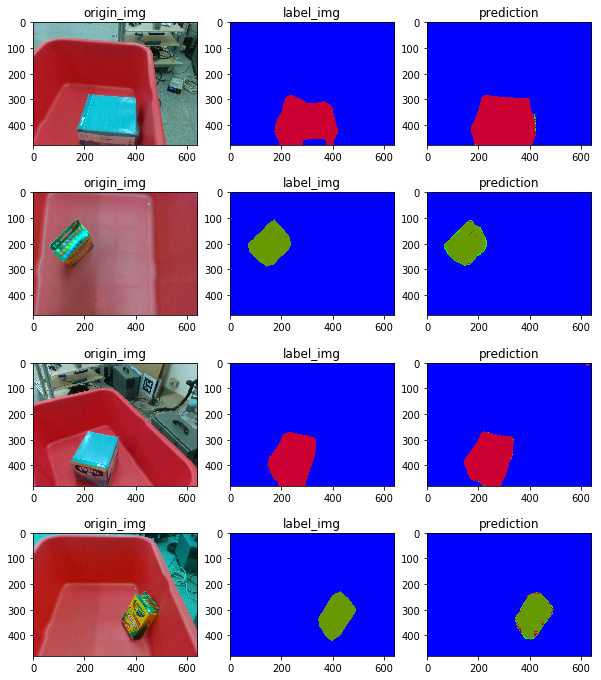

In [16]:
prediction("FCNs_products_20_batch10_epoch0_RMSprop_lr0.0001.pkl")